In [1]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ, l2norm
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
import time

from src.ksd.kernel import l2norm

from src.sensors import Sensor

MCMCKernel = RandomWalkMH # RandomWalkBarker 

In [72]:
X_true = tf.constant([
    [0.15, 0.85],
    [0.2, 0.475],
    [0.35, 0.1],
    [0.45, 0.2],
    [0.55, 0.7],
    [0.6, 0.9],
    [0.85, 0.1],
    [0.85, 0.8],
    [0.5, 0.3], 
    [0.3, 0.7],
    [0.7, 0.7],])

Xob_mask = tf.constant([
    [0., 0.],
    [0., 0.],
    [0., 0.],
    [0., 0.],
    [0., 0.],
    [0., 0.],
    [0., 0.],
    [0., 0.],
    [1., 1.],
    [1., 1.],
    [1., 1.]])

Xob = Xob_mask * X_true

In [79]:
W = tf.constant([
    [0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1.],
    [0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.],
    [1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.],
    [0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.],
    [0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0.],
    [1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.],
    [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
    [0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
    [1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
    [1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.],
    [1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0.]])
assert tf.experimental.numpy.allclose(tf.transpose(W), W), "W needs to be symmetric!"

Y_true = tf.math.sqrt(l2norm(Xb, Xb))
Yob = Y_true * W

(-0.1, 1.1, -0.55, 1.05)

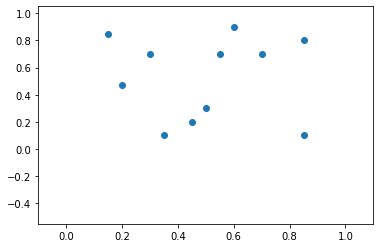

In [80]:
plt.scatter(Xb.numpy()[:, 0], Xb.numpy()[:, 1])
plt.axis(xmin=-0.1, xmax=1.1, ymin=-0.55, ymax=1.05)

In [222]:
class Sensor:
    def __init__(self, Xb: tf.Tensor, Yb: tf.Tensor, W: tf.Tensor):
        self.nsensor = 11
        self.Xb = Xb # 11 x 2
        self.W = W # 11 x 11
        self.Yb = Yb # 11 x 11
        
#     def log_prob(self, x: tf.Tensor):
#         '''
#             x: (n, 16) tensor of (x_{11}, x_{12}, x_{21}, x_{22}, ...)
#         '''
        
#         loglkhd = 0.
#         for j in range(1, self.nsensor):
#             for i in range(min(8, j)):
#                 if j < 8:
#                     diff = x[:, (2*i):(2*i + 2)] - x[:, (2*j):(2*j + 2)] # n x 2
#                 else:
#                     diff = x[:, (2*i):(2*i + 2)] - self.Xb[j, :] # n x 2
                
#                 norm_sq = tf.reduce_sum(diff**2, axis=1, keepdims=True) # n x 1
#                 if self.W[i, j] == 1:
#                     term1 = - norm_sq / (2 * 0.3**2)
#                     term2 = - (self.Yb[i, j] - tf.math.sqrt(norm_sq))**2 / (2 * 0.02**2) # n x 1
#                     loglkhd += term1 + term2 # n x 1
                
#                 else:
#                     loglkhd += tfp.math.log1mexp(norm_sq / (2 * 0.3**2)) # n x 1
#         return loglkhd[0, :] # (1,)

    def log_prob(self, x: tf.Tensor):
        '''
            x: (n, 16) tensor of (x_{11}, x_{12}, x_{21}, x_{22}, ...)
        '''
        
        loglkhd = 0.
        
        for j in range(1, self.nsensor):
            for i in range(min(8, j)):
                if j < 8:
                    diff = x[(2*i):(2*i + 2)] - x[(2*j):(2*j + 2)] # (2,)
                else:
                    diff = x[(2*i):(2*i + 2)] - self.Xb[j, :] # (2,)
                
                norm_sq = tf.reduce_sum(diff**2) # (1,)
                
                if self.W[i, j] == 1:
                    term1 = - norm_sq / (2 * 0.3**2)
                    term2 = - (self.Yb[i, j] - tf.math.sqrt(norm_sq))**2 / (2 * 0.02**2) # (1,)
                    loglkhd += term1 + term2 # (1,)
                
                else:
                    loglkhd += tfp.math.log1mexp(norm_sq / (2 * 0.3**2)) # (1,)
                
#                 loglkhd *= 1.

            print(loglkhd)
            if j == 1:
                return loglkhd
            
        return loglkhd # (1,)

In [223]:
target = Sensor(Xb=Xob, Yb=Yob, W=W)

In [224]:
# xx = tf.reshape(X_true, (1, -1))
xx = tf.reshape(X_true, (-1,))
target.log_prob(xx)

tf.Tensor(-0.6006017, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=-0.6006017>

In [225]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

tf.random.set_seed(1)

dims = 16
# true_stddev = tf.sqrt(tf.linspace(1., 3., dims))
# likelihood = tfd.MultivariateNormalDiag(loc=0., scale_diag=true_stddev)

xx = tf.random.uniform([16])
# xx = tf.zeros(dims)

hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=target.log_prob, #likelihood.log_prob,
      step_size=0.5,
      num_leapfrog_steps=2)

states = tfp.mcmc.sample_chain(
    num_results=1,
    num_burnin_steps=300,
    current_state=xx,
    kernel=hmc_kernel,
    trace_fn=None)

# sample_mean = tf.reduce_mean(states, axis=0)
# ==> approx all zeros


tf.Tensor(-0.09343137, shape=(), dtype=float32)
tf.Tensor(-0.09343137, shape=(), dtype=float32)
tf.Tensor(-0.0011951106, shape=(), dtype=float32)
tf.Tensor(-0.0011951106, shape=(), dtype=float32)
tf.Tensor(-4.4828155e-16, shape=(), dtype=float32)
tf.Tensor(-4.4828155e-16, shape=(), dtype=float32)
tf.Tensor(-4.5805533e-23, shape=(), dtype=float32)
tf.Tensor(-4.5805533e-23, shape=(), dtype=float32)
tf.Tensor(-1.5360437e-31, shape=(), dtype=float32)
tf.Tensor(-1.5360437e-31, shape=(), dtype=float32)
tf.Tensor(-1.8342927e-30, shape=(), dtype=float32)
tf.Tensor(-1.8342927e-30, shape=(), dtype=float32)
tf.Tensor(-1.8107049e-29, shape=(), dtype=float32)
tf.Tensor(-1.8107049e-29, shape=(), dtype=float32)
tf.Tensor(-8.419716e-32, shape=(), dtype=float32)
tf.Tensor(-8.419716e-32, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(-6.095914e-27, shape=(), dtype=float32)
tf.Tensor(-6.095914e-27, shape=(), dtype=float32)
tf.Tensor(-2.5

tf.Tensor(-2.2639163e-31, shape=(), dtype=float32)
tf.Tensor(-2.2639163e-31, shape=(), dtype=float32)
tf.Tensor(-1.8606017e-36, shape=(), dtype=float32)
tf.Tensor(-1.8606017e-36, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


In [217]:
states

<tf.Tensor: shape=(100, 16), dtype=float32, numpy=
array([[ 21.54007  ,  42.970703 ,  15.255394 , ..., -11.194353 ,
          7.419428 ,  16.80661  ],
       [ 21.338818 ,  42.89093  ,  15.850325 , ..., -10.254963 ,
          4.5631485,  16.811481 ],
       [ 19.003819 ,  41.098343 ,  14.700312 , ..., -10.517281 ,
          3.657505 ,  17.379578 ],
       ...,
       [ 28.49722  ,  27.745293 ,  17.847902 , ..., -12.907913 ,
         -2.7484493,  22.405975 ],
       [ 29.146988 ,  27.158375 ,  18.882593 , ..., -13.248932 ,
         -5.7028923,  21.503765 ],
       [ 28.514832 ,  28.140678 ,  20.25731  , ..., -12.443443 ,
         -4.859289 ,  20.98875  ]], dtype=float32)>

# Van Dyk's paper

In [42]:
# Observation indicators from the fifth sensor (1st column) to the first four sensors
# and those from the sixth sensor (2nd column) to the first four sensors.
Ob = tf.constant([1., 0, 1, 0, 1, 0, 1, 0])
Ob = tf.transpose(tf.reshape(Ob, (2, -1)))

# Observation indicators among the first four sensors. 
Os = tf.constant([[0., 0, 0, 1],
              [0, 0, 1, 1],
              [0, 1, 0, 0],
              [1, 1, 0, 0]])

# Each row indicates the location of the known sensors (5th and 6th).
Xb = tf.constant([0.5, 0.3, 0.3, 0.7])
Xb = tf.transpose(tf.reshape(Xb, (2, -1)))

# Each row indicates the location of the unknown sensors (1st, 2nd, 3rd, and 4th).
Xs = tf.constant([0.5748, 0.0991, 0.2578, 0.8546, 
               0.9069, 0.3651, 0.1350, 0.0392])
Xs = tf.transpose(tf.reshape(Xs, (2, -1)))

# The observed distances from the fifth sensor (1st column) to the first four sensors
# and those from the sixth sensor (2nd column) to the first four sensors.
Yb = tf.constant([0.6103, 0, 0.2995, 0, 
               0.3631, 0, 0.5656, 0])
Yb = tf.transpose(tf.reshape(Yb, (2, -1)))

# Observed distances among the first four sensors.
Ys = tf.constant([[0, 0, 0, 0.9266],
               [0, 0, 0.2970, 0.8524],
               [0, 0.2970, 0, 0],
               [0.9266, 0.8524, 0, 0]])

In [43]:
loc_true = tf.constant([
    0.57, 0.91,
    0.10, 0.37,
    0.26, 0.14,
    0.85, 0.04,
#     0.50, 0.30,
#     0.30, 0.70
])

tf.random.set_seed(1)

loc = tf.random.uniform((2, 8))

target = Sensor(Ob, Os, Xb, Xs, Yb, Ys)
log_prob_fn = target.log_prob

loc2 = tf.concat([loc, loc, loc], axis=0)
log_prob_fn(loc2)

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([-689.25555, -365.59918, -689.25555, -365.59918, -689.25555,
       -365.59918], dtype=float32)>

In [45]:
dim = 8

n = 1000
# ind = tf.range(start=0, limit=200000, delta=200000//1000)
ind = tf.range(start=0, limit=100000, delta=100000//1000)

mcmc_res = pd.read_csv("res/sensors/res_ram.csv")
# mcmc_res = pd.read_csv("res/sensors/res_mt.csv")
samples_off = tf.constant(mcmc_res.loc[ind].to_numpy(), dtype=tf.float32)

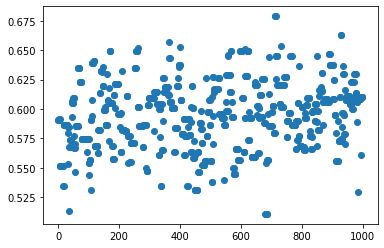

In [46]:
# samples_off = mcmc_res.to_numpy()
_ = plt.scatter(range(samples_off.shape[0]), samples_off[:, 0])

In [47]:
def plot_sensors(x, lims=None):
    n = x.shape[0]
    x = tf.reshape(x, (n*4, 2)).numpy()
    loc_true_np = tf.reshape(loc_true, (4, 2)).numpy()
    plot_df = pd.DataFrame({"x0": x[:, 0], "x1": x[:, 1], 
                            "sensor": ["1", "2", "3", "4"] * n})
    loc_true_df = pd.DataFrame({"x0": loc_true_np[:, 0], "x1": loc_true_np[:, 1],
                            "sensor": ["1", "2", "3", "4"]})
    
    sns.scatterplot(data=plot_df, x="x0", y="x1", hue="sensor")
    sns.scatterplot(data=loc_true_df, x="x0", y="x1", color="black", label="true")
    if lims is not None:
        _ = plt.axis(xmin=lims[0], xmax=lims[1], ymin=lims[2], ymax=lims[3])
        
def show_jumps(x, lims=None, mode_list=None):
    mode_list = [tf.reshape(x, (4, 2)) for x in mode_list]
    
    plot_sensors(x, lims=None)
    
    nmodes = len(mode_list)
    for i in range(nmodes):
        for j in range(i+1, nmodes):
            mode1, mode2 = mode_list[i], mode_list[j]
            for k in range(4):
                _ = plt.plot(mode1[k], mode2[k], linewidth=2)

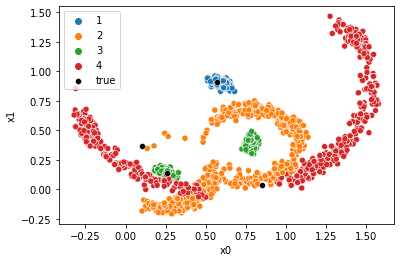

In [48]:
plot_sensors(samples_off)

In [49]:
print(log_prob_fn(tf.constant(
    [[-0.04030127,  0.5771746 ,  1.0083778 ,  0.21558024,  0.77958536, 0.40376794,  0.31509128, -0.27444535]])))
print(log_prob_fn(tf.constant(
    [[0.6030127,  0.9 ,  1.0083778 ,  0.21558024,  0.77958536, 0.40376794,  0.31509128, -0.27444535]])))

tf.Tensor([5.387394], shape=(1,), dtype=float32)
tf.Tensor([-98.090355], shape=(1,), dtype=float32)


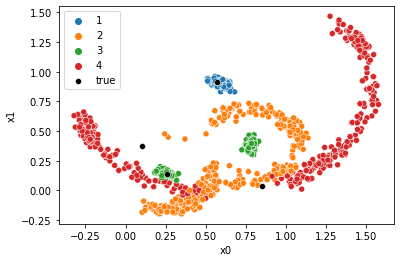

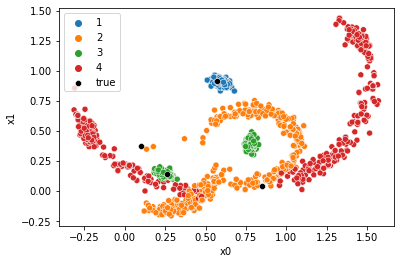

In [50]:
tf.random.set_seed(1)

ntrain = n // 2

samples_init = samples_off

samples_init = tf.random.shuffle(samples_init) # shuffle
samples_init = samples_init[::-1] #!

sample_off_train, sample_off_test = samples_init[:ntrain, ], samples_init[ntrain:, ]

plot_sensors(sample_off_train)
plt.show()
plot_sensors(sample_off_test)
plt.show()

In [51]:
threshold = 1e-2

# start_pts = sample_off_train
start_pts = tf.concat([
        sample_off_train[:(ntrain//2)], 
        tf.random.uniform(shape=(ntrain//2, dim), minval=-1., maxval=1.),
    ], axis=0)

tic = time.perf_counter()
mode_list, inv_hess_list = find_modes(start_pts, log_prob_fn, grad_log=None, threshold=threshold,
                                      max_iterations=10000) #1e-10)
toc = time.perf_counter()
print(f"Optimisation finished in {toc - tic:0.4f} seconds")
len(mode_list)

Optimisation finished in 132.5712 seconds


6

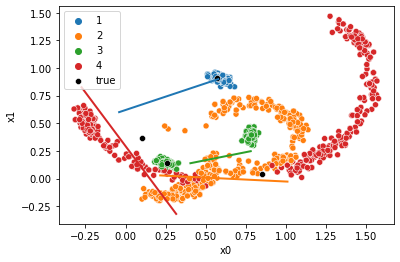

In [52]:
show_jumps(sample_off_train, mode_list=mode_list[:2])

In [53]:
mode_list, inv_hess_list

([<tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([-0.0403011 ,  0.57717955,  1.0084094 ,  0.21560761,  0.7795828 ,
          0.40376103,  0.31512836, -0.27442324], dtype=float32)>,
  <tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([ 0.6010137 ,  0.8994251 , -0.02684856,  0.02904511,  0.24810009,
          0.1393157 , -0.3188936 ,  0.8259986 ], dtype=float32)>,
  <tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([0.60013425, 0.9003874 , 1.07147   , 0.35074416, 0.77970105,
         0.40273878, 1.5049161 , 1.0803405 ], dtype=float32)>,
  <tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([-0.04039523,  0.58012223,  0.11466104, -0.12579216,  0.24997291,
          0.13788602, -0.7289747 , -0.03377881], dtype=float32)>,
  <tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([-0.04015435,  0.5788235 ,  1.0322889 ,  0.55984175,  0.7796818 ,
          0.40510342,  0.56965524,  1.271458  ], dtype=float32)>,
  <tf.Tensor: shape=(8,), dtype=float32, numpy=
  array([-0.03984733

In [54]:
#! impose inv hessians
inv_hess_list = [tf.eye(8)] * len(inv_hess_list)

In [55]:
#! select only two modes
mode_list, inv_hess_list = mode_list[:2], inv_hess_list[:2]

In [56]:
tf.linalg.det(inv_hess_list[0])

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

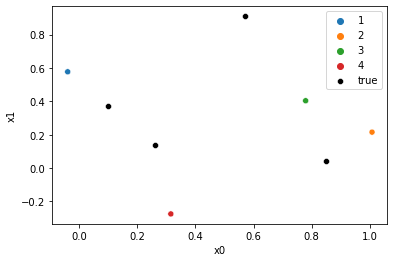

In [57]:
## location of first mode
plot_sensors(tf.stack(mode_list, axis=0)[:1])

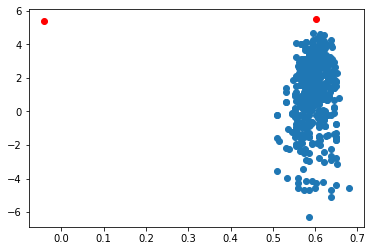

In [58]:
xx = sample_off_train.numpy()
_ = plt.scatter(xx[:, 0], log_prob_fn(xx))
yy = tf.stack(mode_list, axis=0)
_ = plt.scatter(yy[:, 0], log_prob_fn(yy), color="red")

In [60]:
proposal_dict = mcmc.prepare_proposal_input_all(mode_list=mode_list, inv_hess_list=inv_hess_list)

In [61]:
_, ind_pair_list = pairwise_directions(mode_list, return_index=True)

In [62]:
std = [1., .9]

In [65]:
T = 50

xx = sample_off_train#[sample_off_train[:, 0] < 0.3]

mh = MCMCKernel(log_prob=log_prob_fn)
mh.run(steps=T, std=std, x_init=xx, ind_pair_list=ind_pair_list, **proposal_dict)

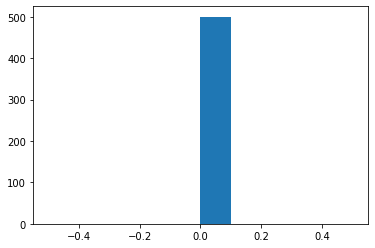

In [114]:
xx = (np.sum(mh.if_accept.numpy() == 1., axis=0)).astype(np.float32)
_ = plt.hist(xx)

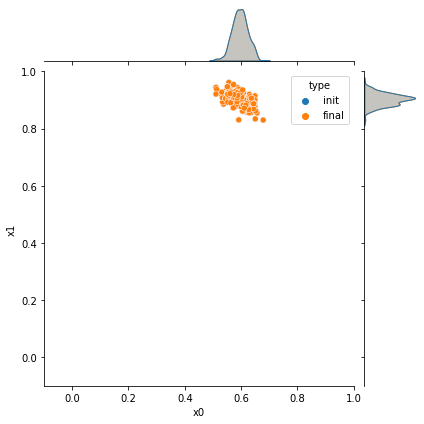

In [67]:
x_all = mh.x[0] #!

x_0 = x_all[0, :, :].numpy()
x_t = x_all[-1, :, :].numpy()

x0_df = pd.DataFrame({f"x{i}": x_0[:, i] for i in range(dim)})
x0_df["type"] = "init"

xt_df = pd.DataFrame({f"x{i}": x_t[:, i] for i in range(dim)})
xt_df["type"] = "final"

xtrain_df = pd.DataFrame({f"x{i}": samples_off[:, i] for i in range(dim)})
xtrain_df["type"] = "mcmc"


perturbed_df = pd.concat([
#     xtrain_df, 
    x0_df, 
    xt_df], ignore_index=True)

_ = sns.jointplot(data=perturbed_df, x="x0", y="x1", hue="type",
                  xlim=(-.1, 1.),
                  ylim=(-.1, 1.),
 )

In [44]:
np.sum((x_t[:, 0] > 0.2))

500

In [36]:
num_boot = 800
alpha = 0.05
nrep = 1

kernel = IMQ(med_heuristic=True)
ksd = KSD(target=target, kernel=kernel)
bootstrap = Bootstrap(ksd, n//2)

In [37]:
multinom_samples = bootstrap.multinom.sample((nrep, num_boot))
multinom_one_sample = multinom_samples[0, :]

In [38]:
_, p_val_no_pert = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_0, multinom_samples=multinom_one_sample)

_, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)
print("before: ", p_val_no_pert, "\nafter:", p_val)

before:  0.43820224719101125 
after: 0.43820224719101125


In [95]:
def experiment(n, target_dist, samples_init, sample_init_train, sample_init_test):
    jump_ls = tf.linspace(0.9, 1.1, 2)
    
    ntrain = n // 2
    threshold = 1e-2
    nrep = 1

    num_boot = 800
    alpha = 0.05
    T = 1000
    
    kernel = IMQ(med_heuristic=True)
    ksd = KSD(target=target_dist, kernel=kernel)
    bootstrap = Bootstrap(ksd, n-ntrain)
    
    multinom_samples = bootstrap.multinom.sample((nrep, num_boot))

    p_val_list = []
    jump_ratio_list = []

    i = 0
    # sample data
    start_pts = tf.concat([
        sample_init_train[:(ntrain//2)], 
        tf.random.uniform(shape=(ntrain//2, dim), minval=0., maxval=1.)], axis=0)

    plot_sensors(sample_off_train)
    plt.show()
    plot_sensors(sample_off_test)
    plt.show()
    
    # find modes
    print("searching for modes")
    mode_list, inv_hess_list = find_modes(start_pts, log_prob_fn, grad_log=None, threshold=threshold)
    
    #!
    inv_hess_list = [tf.eye(8)] * len(inv_hess_list)

    proposal_dict = mcmc.prepare_proposal_input_all(mode_list=mode_list, inv_hess_list=inv_hess_list)
    _, ind_pair_list = pairwise_directions(mode_list, return_index=True)

    print("running in parallel ...")
    tic = time.perf_counter()

    # find best jump scale
    mh = MCMCKernel(log_prob=log_prob_fn)
    mh.run(steps=T, std=jump_ls, x_init=sample_init_train, ind_pair_list=ind_pair_list, **proposal_dict)

    # compute ksd
    scaled_ksd_vals = []
    for j in range(jump_ls.shape[0]):
        x_t = mh.x[j, -1, :, :]
        _, ksd_val = ksd.h1_var(X=x_t, Y=tf.identity(x_t), return_scaled_ksd=True)
        ksd_val = ksd_val
        
        scaled_ksd_vals.append(ksd_val)
    
    toc = time.perf_counter()
    print(f"... done in {toc - tic:0.4f} seconds")
    best_jump = jump_ls[tf.math.argmax(scaled_ksd_vals)]

    # mh perturbation
    mh = MCMCKernel(log_prob=log_prob_fn)
    mh.run(steps=T, std=best_jump, x_init=sample_off_test, 
           ind_pair_list=ind_pair_list, **proposal_dict)
    x_0 = mh.x[0, :, :]
    x_t = mh.x[-1, :, :]

    # compute p-value
    kernel = IMQ(med_heuristic=True)
    ksd = KSD(target=target_dist, kernel=kernel)
    bootstrap = Bootstrap(ksd, n)

    multinom_one_sample = multinom_samples[i, :]

    _, p_val0 = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_0, multinom_samples=multinom_one_sample)
    _, p_valt = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)

    p_val_list.append(p_val0) # no perturbation
    jump_ratio_list.append(-1.)
    
    p_val_list.append(p_valt)
    jump_ratio_list.append(best_jump)
        
    res = pd.DataFrame({"pval": p_val_list, "jump": jump_ratio_list})
    
    return res, best_jump, scaled_ksd_vals

In [80]:
tf.random.set_seed(1)
tic = time.perf_counter()
res_df, best_jump, scaled_ksd_vals = experiment(n, target, samples_init=samples_off,
                              sample_init_train=sample_off_train,
                              sample_init_test=sample_off_test,
                              )
toc = time.perf_counter()
print(f"Finished in {toc - tic:0.4f} seconds")

searching for modes
running in parallel ...
... done in 2.8271 seconds
[<tf.Tensor: shape=(), dtype=float32, numpy=0.101100944>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1036815>]
[0.8999999761581421, 1.100000023841858]
tf.Tensor(0.9, shape=(), dtype=float32)
Finished in 99.2960 seconds


In [81]:
print(res_df)

       pval                                     jump
0  0.187266                                     -1.0
1  0.091136  tf.Tensor(0.9, shape=(), dtype=float32)


'searching for modes\nrunning in parallel ...\n... done in 195.8319 seconds\nFinished in 262.7997 seconds'

In [94]:
res_df.to_csv("haha.csv", index=False)